# Skin Cancer Classification

## LIBRARIES

In [1]:
import tensorflow as tf
import keras.backend as K
from tensorflow import keras    
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, RandomCrop, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os, cv2

# The next line for using GPU through CUDA core for computitation
# Comment all lines if you don't have NVIDIA CUDA GPU 
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## DATASET
**You can find the DATA [HERE](https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000)**

**Dataset overview:**
Training of neural networks for automated diagnosis of pigmented skin lesions is hampered by the small size and lack of diversity of available dataset of dermatoscopic images. We tackle this problem by releasing the HAM10000 ("Human Against Machine with 10000 training images") dataset. We collected dermatoscopic images from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes.

Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions:
- Actinic keratoses and intraepithelial carcinoma Bowen's disease **(akiec)**
- basal cell carcinoma **(bcc)**
- benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, **bkl**)
- dermatofibroma **(df)**
- melanoma **(mel)**
- melanocytic nevi **(nv)**
- vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, **vasc**).

More than 50% of lesions are confirmed through histopathology **(histo)**, the ground truth for the rest of the cases is either follow-up examination **(follow_up)**, expert consensus **(consensus)**, or confirmation by in-vivo confocal microscopy **(confocal)**. The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

In [2]:
# Read Images Data into DataFrame fro, Model Training
ImagesData = pd.read_csv('Skin-Cancer-MNIST-HAM10000/hmnist_28_28_RGB.csv')

In [5]:
# Split Training features and the Label (x,y)
y = ImagesData['label']
x = ImagesData.drop(columns = ['label'])

In [6]:
# Read Images Metadata file into DataFrame 
MetaData = pd.read_csv('skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
MetaData.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
# Define Calsses mentioned in Data overview and located in Metadat file dx column as dict with key as encoding alphaptically ordered.
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2: ('bkl', 'benign keratosis-like lesions'),
           1: ('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

Text(0.5, 1.0, 'Frequency Distribution of Classes')

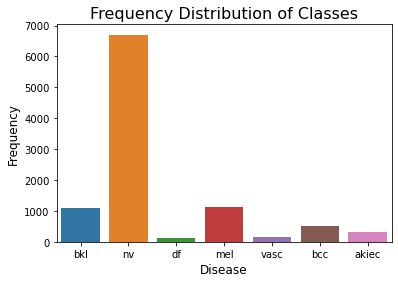

In [8]:
# polt Frequency distribution of the data
sns.countplot(x = 'dx', data = MetaData)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

Text(0.5, 1.0, 'Gender of Patient')

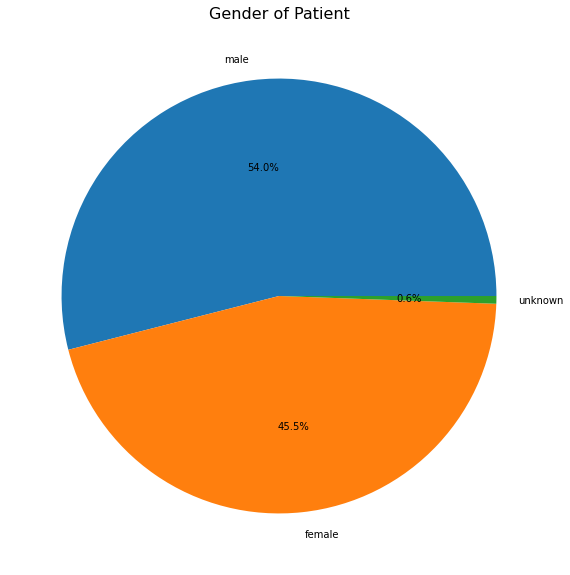

In [9]:
# Plot the total percentage of gender exist in the data
bar, ax = plt.subplots(figsize = (10,10))
plt.pie(MetaData['sex'].value_counts(), labels = MetaData['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

Text(0.5, 1.0, 'Histogram of Age of Patients')

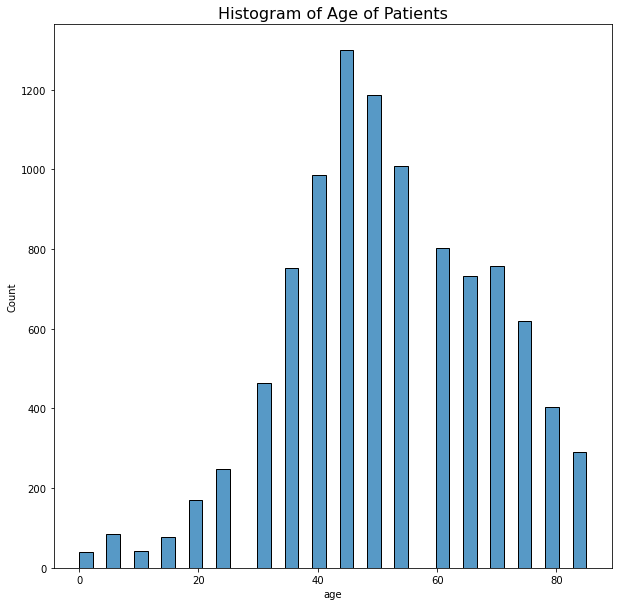

In [10]:
# Plot the distribution of data over the age of patient
bar, ax = plt.subplots(figsize=(10,10))
sns.histplot(MetaData['age'])
plt.title('Histogram of Age of Patients', size=16)

In [11]:
# over-sample the minority classes by picking samples at random with replacement.
OverSampler = RandomOverSampler()
x, y  = OverSampler.fit_resample(x, y)

In [12]:
print(np.array(x).shape)

(46935, 2352)


In [13]:
# reshape 
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (46935, 28, 28, 3)


In [14]:
# Data Normalization
x = (x-np.mean(x)) / np.std(x)

# Train- Test Split
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

In [15]:
# Initiate Keras Sequential Model
model = Sequential()

model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model.add(Flatten()) # Flatten feature-map or Extracted weights to 1D tensor.
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax')) # Dense with 7 units (NUMBER OF CLASSES) and Softmax Activation for Categorical classification

# Print The model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                    

In [16]:
# custom callback function to save the weights weverytime the validation accuracy increases
callback = tf.keras.callbacks.ModelCheckpoint(filepath='HAM_Model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)

In [17]:
# Compile Model with Sparse categorical crossentropy (0,1,2,...), Adam Optimizer, and look for the Accuracy metric.
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])

In [18]:
# Fit training and validation data to the model for training process 
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 20,
                    callbacks=[callback])

Epoch 1/20
235/235 [==============================] - ETA: 0s - loss: 1.2277 - accuracy: 0.5231
Epoch 1: saving model to HAM_Model.h5
235/235 [==============================] - 5s 12ms/step - loss: 1.2277 - accuracy: 0.5231 - val_loss: 0.9188 - val_accuracy: 0.6421
Epoch 2/20
231/235 [============================>.] - ETA: 0s - loss: 0.7234 - accuracy: 0.7346
Epoch 2: saving model to HAM_Model.h5
235/235 [==============================] - 2s 10ms/step - loss: 0.7206 - accuracy: 0.7356 - val_loss: 0.5774 - val_accuracy: 0.7908
Epoch 3/20
230/235 [============================>.] - ETA: 0s - loss: 0.4739 - accuracy: 0.8313
Epoch 3: saving model to HAM_Model.h5
235/235 [==============================] - 3s 11ms/step - loss: 0.4718 - accuracy: 0.8320 - val_loss: 0.3972 - val_accuracy: 0.8583
Epoch 4/20
232/235 [============================>.] - ETA: 0s - loss: 0.3289 - accuracy: 0.8811
Epoch 4: saving model to HAM_Model.h5
235/235 [==============================] - 3s 11ms/step - loss: 0.32

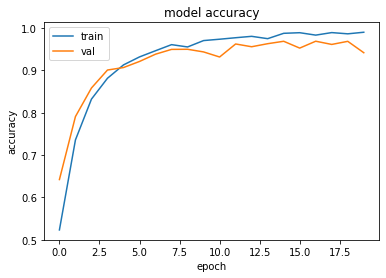

In [19]:
# Plot Model Training and Validation Accuracy during learning period
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

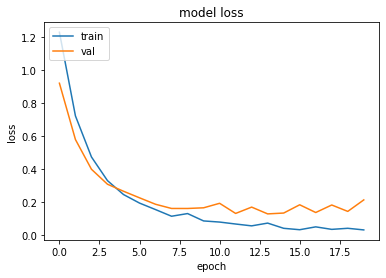

In [20]:
# # Plot Model Training and Validation Loss during learning period
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
# Evauate the model with the test data
loss, acc = model.evaluate(X_test, Y_test, verbose=1)

294/294 [==============================] - 1s 3ms/step - loss: 0.2328 - accuracy: 0.9374


In [22]:
# load saved Model
model = keras.models.load_model('HAM_Model.h5')

In [23]:
# Evalue Again after saving 
loss, acc = model.evaluate(X_test, Y_test, verbose=1)

294/294 [==============================] - 1s 3ms/step - loss: 0.2328 - accuracy: 0.9374


In [24]:
# prediction on test data 
Y_pred = model.predict(X_test)

294/294 [==============================] - 1s 2ms/step


In [25]:
# Returns the indices of the maximum values along an axis.
y_pred = np.argmax(Y_pred, axis=1)

In [26]:
# Generate Confusion Matrix
cf_matrix = confusion_matrix(Y_test, y_pred)

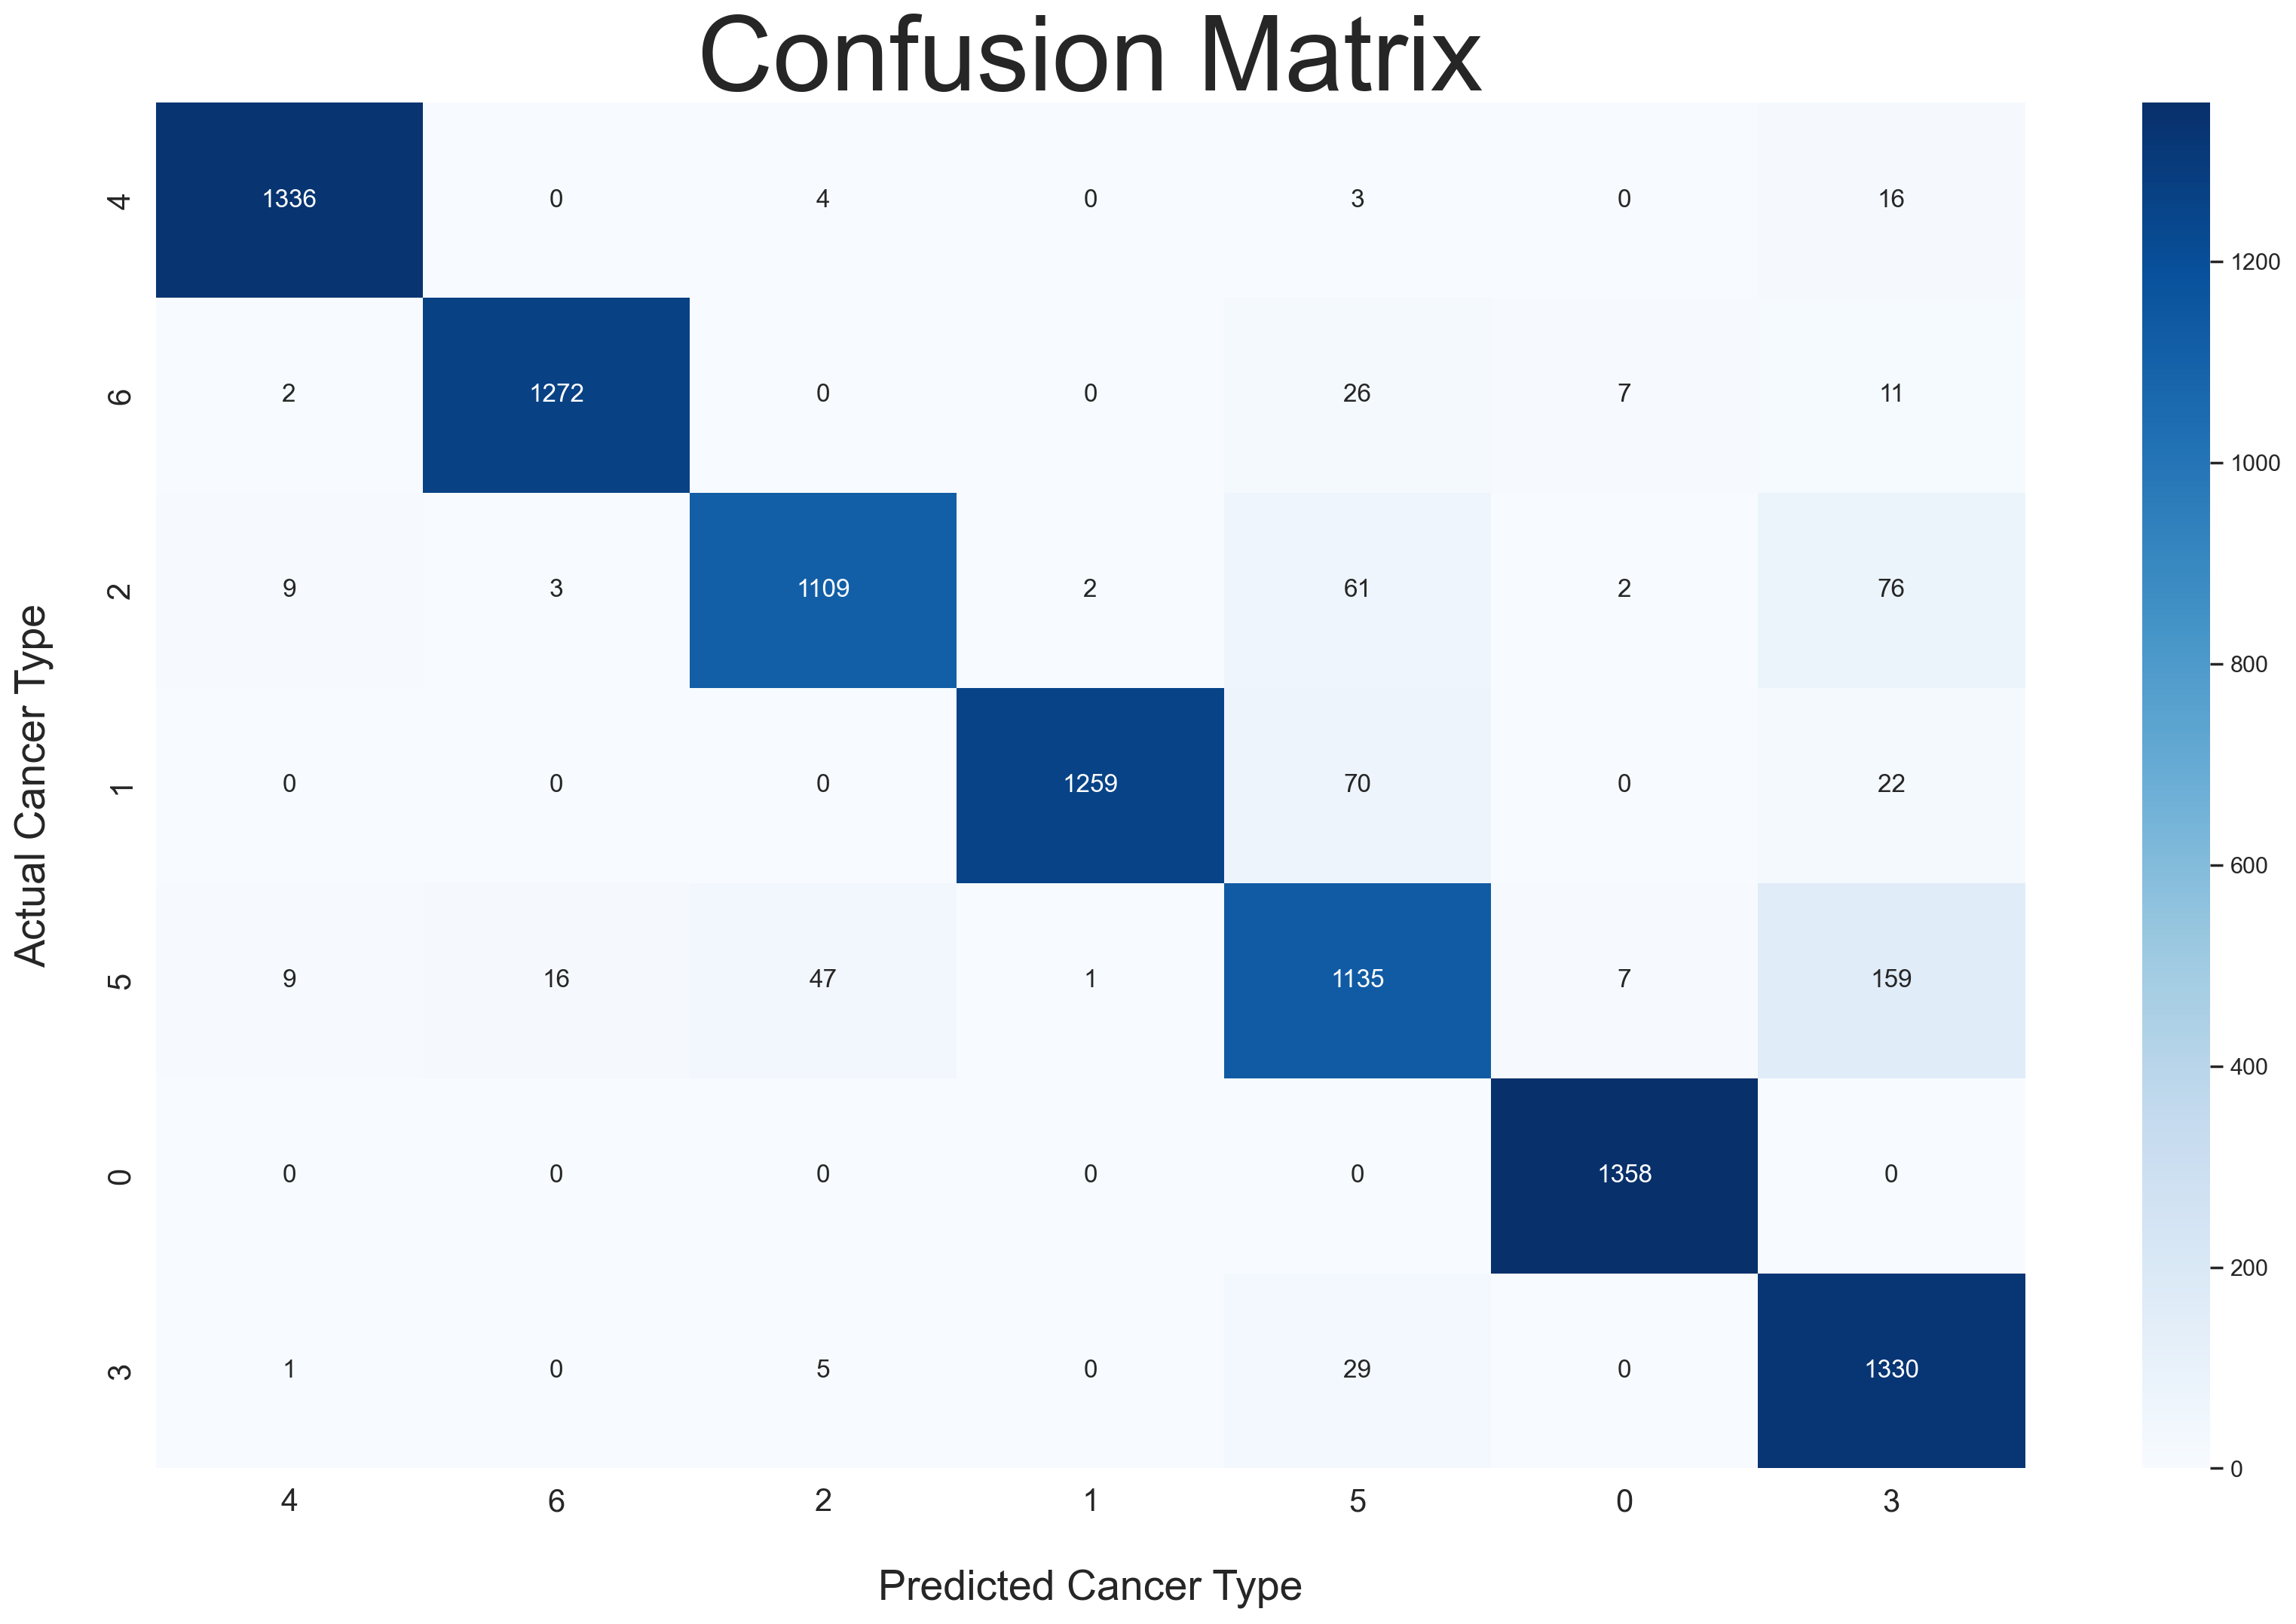

In [27]:
# Plot the Confusion Matrics
plt.figure(figsize=(20,12), dpi=200)
sns.set(font_scale= 1)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Confusion Matrix',fontsize=50);
ax.set_xlabel('\nPredicted Cancer Type',fontsize=20)
ax.set_ylabel('Actual Cancer Type\n',fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes,fontsize=15)
ax.yaxis.set_ticklabels(classes,fontsize=15)
#plt.savefig('Confusion_Matrix.png')
## Display the visualization of the Confusion Matrix.
plt.show()

In [28]:
# Name of classes
classesList = [
    'melanocytic nevi',
    'melanoma',
    'benign keratosis-like lesions',
    'basal cell carcinoma',
    'pyogenic granulomas and hemorrhage',
    'Actinic keratoses and intraepithelial carcinomae',
    'dermatofibroma',
    ]
# Print classification report for the model
print(classification_report(Y_test,y_pred, target_names=classesList))

                                                  precision    recall  f1-score   support

                                melanocytic nevi       0.98      0.98      0.98      1359
                                        melanoma       0.99      0.97      0.98      1318
                   benign keratosis-like lesions       0.95      0.88      0.91      1262
                            basal cell carcinoma       1.00      0.93      0.96      1351
              pyogenic granulomas and hemorrhage       0.86      0.83      0.84      1374
Actinic keratoses and intraepithelial carcinomae       0.99      1.00      0.99      1358
                                  dermatofibroma       0.82      0.97      0.89      1365

                                        accuracy                           0.94      9387
                                       macro avg       0.94      0.94      0.94      9387
                                    weighted avg       0.94      0.94      0.94      9387

